### Workflow with Orchestration

Implements the following design pattern:
* https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker
* in this version the json schema is derived (using: model_json_schema())

In [1]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

from oci_models import create_model_for_routing, create_model_for_answer_directly

In [2]:
# models used in the rest of the code
llm = create_model_for_routing()
llm_ad = create_model_for_answer_directly()


# Schema for structured output to use in planning
class Section(BaseModel):
    """
    section
    """

    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    """
    sections
    """

    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Graph state
class State(TypedDict):
    """
    workflow state
    """

    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    """
    workflow state
    """

    section: Section
    completed_sections: Annotated[list, operator.add]


# Augment the LLM with schema for structured output
json_schema = Sections.model_json_schema()

planner = llm.with_structured_output(json_schema)

In [3]:
# Nodes
def orchestrator(state: State):
    """Orchestrator: generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            HumanMessage(
                content=f"""Generate a plan for the report.\n
            Follow strictly the following JSON SCHEMA: {str(json_schema)}
            Here is the report topic: {state['topic']}
            """
            ),
        ]
    )

    # print(type(report_sections))
    # print(report_sections)

    return {"sections": report_sections["sections"]}


def llm_call(state: WorkerState):
    """a Worker, writes a section of the report"""

    # Generate section
    # we're using another model
    section = llm_ad.invoke(
        [
            SystemMessage(
                content="""Write a report section following the provided name and description. 
                Include no preamble for each section. Use markdown formatting."""
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section']['name']} and description: {state['section']['description']}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for i, s in enumerate(state["sections"]):
        print(
            f"{i+1} Calling llm for section {s['name']}\nDescription: {s['description']}"
        )

    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [4]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

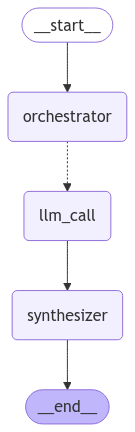

In [5]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [8]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on AI Agents"})

1 Calling llm for section Introduction
Description: An overview of the report and its purpose.
2 Calling llm for section What are AI Agents?
Description: A definition of AI agents and their role in AI.
3 Calling llm for section Types of AI Agents
Description: A discussion of the different types of AI agents, including their capabilities and applications.
4 Calling llm for section AI Agent Development
Description: An exploration of the process of creating AI agents, including the technologies and techniques involved.
5 Calling llm for section AI Agent Applications
Description: A review of the various sectors and industries where AI agents are being utilized, with examples.
6 Calling llm for section Conclusion
Description: A summary of the key points covered in the report.


In [9]:
Markdown(state["final_report"])

### Introduction and Description
#### Overview of the Report
The purpose of this report is to provide a comprehensive overview of the current state of affairs in the industry, highlighting key trends, challenges, and opportunities. It aims to inform stakeholders, including investors, policymakers, and industry professionals, about the latest developments and their potential impact on the market.

#### Purpose of the Report
The report seeks to achieve the following objectives:
* Identify and analyze the major drivers of change in the industry
* Examine the current market landscape and forecast future trends
* Evaluate the potential risks and opportunities associated with emerging technologies and innovations
* Provide recommendations for stakeholders to navigate the changing landscape and capitalize on new opportunities.

---

### What are AI Agents?
AI agents are autonomous entities that use artificial intelligence to perceive their environment, make decisions, and take actions to achieve specific goals. They are programmed to perform tasks independently, using algorithms and data to guide their behavior. AI agents can be simple or complex, ranging from chatbots that respond to basic queries to sophisticated systems that can learn, reason, and adapt to new situations. Their role in AI is to interact with users, other agents, or the environment to accomplish tasks, provide services, or solve problems. AI agents can be categorized into different types, including:
* **Reactive agents**: respond to the current state of the environment without considering future consequences
* **Proactive agents**: anticipate and plan for future events to achieve their goals
* **Autonomous agents**: operate independently without human intervention
* **Social agents**: interact with other agents or humans to achieve common goals or provide services.

---

### Types of AI Agents
There are several types of AI agents, each with its own unique capabilities and applications. 
#### Simple Reflex Agents
* React to the current state of the environment
* Do not have the ability to learn or remember past experiences
* Examples include thermostats and basic chatbots
#### Model-Based Reflex Agents
* Maintain an internal model of the environment
* Use this model to make decisions and take actions
* Examples include autonomous vehicles and robots
#### Goal-Based Agents
* Have specific goals and objectives
* Use planning and decision-making to achieve these goals
* Examples include virtual assistants and scheduling systems
#### Utility-Based Agents
* Make decisions based on a utility function that estimates the desirability of each action
* Examples include recommender systems and game-playing AI
#### Learning Agents
* Have the ability to learn from experience and improve over time
* Examples include machine learning algorithms and neural networks
These types of AI agents have a wide range of applications, including robotics, healthcare, finance, and education. 
Each type of agent has its own strengths and weaknesses, and the choice of agent depends on the specific problem or task at hand.

---

### AI Agent Development
#### Introduction to AI Agents
AI agents are computer programs that use artificial intelligence to perform tasks autonomously. The development of AI agents involves a range of technologies and techniques, including machine learning, natural language processing, and computer vision.

#### Technologies Involved
The development of AI agents relies on several key technologies, including:
* **Machine Learning**: a type of artificial intelligence that enables agents to learn from data and improve their performance over time
* **Natural Language Processing**: a technology that enables agents to understand and generate human language
* **Computer Vision**: a technology that enables agents to interpret and understand visual data from images and videos
* **Robotics**: a technology that enables agents to interact with the physical world

#### Techniques Involved
The development of AI agents also involves several key techniques, including:
* **Reinforcement Learning**: a type of machine learning that enables agents to learn from trial and error
* **Deep Learning**: a type of machine learning that enables agents to learn complex patterns in data
* **Knowledge Representation**: a technique that enables agents to represent and reason about knowledge
* **Planning and Decision-Making**: techniques that enable agents to make decisions and plan actions

#### Applications of AI Agents
AI agents have a wide range of applications, including:
* **Virtual Assistants**: AI agents that can perform tasks such as scheduling appointments and sending emails
* **Autonomous Vehicles**: AI agents that can control and navigate vehicles
* **Chatbots**: AI agents that can have conversations with humans
* **Robotics**: AI agents that can interact with the physical world and perform tasks such as assembly and manufacturing

#### Challenges and Limitations
The development of AI agents also poses several challenges and limitations, including:
* **Ethics and Safety**: ensuring that AI agents behave in an ethical and safe manner
* **Explainability and Transparency**: understanding how AI agents make decisions and take actions
* **Security**: protecting AI agents from cyber threats and attacks
* **Scalability**: developing AI agents that can scale to meet the needs of large and complex systems.

---

### AI Agent Applications
AI agents are being utilized in a wide range of sectors and industries, including:
* **Healthcare**: AI agents are being used to analyze medical images, diagnose diseases, and develop personalized treatment plans. For example, IBM's Watson for Oncology is an AI agent that helps doctors develop treatment plans for cancer patients.
* **Finance**: AI agents are being used to detect fraud, manage investments, and provide customer service. For example, chatbots are being used by banks to provide 24/7 customer support and help customers with transactions.
* **Transportation**: AI agents are being used to develop autonomous vehicles, optimize traffic flow, and improve logistics. For example, Waymo's self-driving cars use AI agents to navigate roads and avoid obstacles.
* **Education**: AI agents are being used to develop personalized learning plans, grade assignments, and provide tutoring. For example, AI-powered adaptive learning systems are being used to help students learn math and reading skills.
* **Customer Service**: AI agents are being used to provide 24/7 customer support, answer frequently asked questions, and help customers with transactions. For example, Amazon's Alexa and Google Home are using AI agents to provide customer support and answer questions.
* **Cybersecurity**: AI agents are being used to detect and prevent cyber attacks, identify vulnerabilities, and improve incident response. For example, AI-powered security systems are being used to detect and prevent malware and ransomware attacks.
* **Manufacturing**: AI agents are being used to optimize production processes, predict maintenance needs, and improve product quality. For example, AI-powered predictive maintenance systems are being used to predict when equipment is likely to fail and schedule maintenance accordingly.
* **Retail**: AI agents are being used to personalize marketing, optimize inventory management, and improve customer experience. For example, AI-powered chatbots are being used by retailers to provide personalized product recommendations and help customers with transactions.

---

### Conclusion
The report has covered various key points, highlighting the main aspects of the subject matter. The primary findings and observations have been presented, providing a comprehensive overview of the topic. The main points can be summarized as follows: 
* Key findings have been identified and analyzed
* Key observations have been presented and discussed
* The implications of the findings have been considered and evaluated
* Recommendations for future actions have been proposed and outlined. 
Overall, the report has provided a detailed examination of the subject, highlighting the essential elements and takeaways.